In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Cell 1: Imports and configuration
import os
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, auc,
    silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
)

# Supervised models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Unsupervised/clustering and outlier detection
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook")

DATA_PATH = "Network_anomaly_data.csv"  # adjust if needed
RANDOM_STATE = 42
TARGET_MODE = "binary"  # "binary" (Normal vs Attack) or "multiclass" (families)
TEST_SIZE = 0.25
N_SPLITS = 5

# Optional caps for heavy models/plots
SAMPLE_FOR_SVC = 60000   # subsample rows for SVC if dataset is very large; set None to disable
TSNE_SAMPLE = 4000       # subsample rows for t-SNE; set None to disable

In [3]:
# Cell 2: Load data, standardize columns, and feature engineering

df = pd.read_csv(DATA_PATH, low_memory=False)
df.columns = [c.strip().lower() for c in df.columns]
print(f"Loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")

label_col = "attack" if "attack" in df.columns else None

# Attack binary and family mapping (KDD-like)
if label_col:
    df["attack_binary"] = np.where(df[label_col].str.lower() == "normal", "Normal", "Attack")

    dos = {"neptune","smurf","teardrop","pod","back","land"}
    probe = {"satan","ipsweep","portsweep","nmap"}
    r2l = {"guess_passwd","ftp_write","multihop","phf","imap","warezmaster","warezclient","spy"}
    u2r = {"buffer_overflow","loadmodule","rootkit","perl"}

    def map_family(x: str) -> str:
        if pd.isna(x): return "Unknown"
        xl = str(x).lower()
        if xl == "normal": return "Normal"
        if xl in dos: return "DoS"
        if xl in probe: return "Probe"
        if xl in r2l: return "R2L"
        if xl in u2r: return "U2R"
        return "OtherAttack"

    df["attack_family"] = df[label_col].apply(map_family)

# Column helpers
def coalesce_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    lower_map = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in lower_map:
            return lower_map[c.lower()]
    return None

srcbytes_col = coalesce_col(df, ["srcbytes", "src_bytes", "source_bytes"])
dstbytes_col = coalesce_col(df, ["dstbytes", "dst_bytes", "dest_bytes", "destination_bytes"])
duration_col = coalesce_col(df, ["duration"])

# Light feature engineering: logs and simple ratios (if available)
if srcbytes_col:
    df["log_srcbytes"] = np.log1p(pd.to_numeric(df[srcbytes_col], errors="coerce"))
if dstbytes_col:
    df["log_dstbytes"] = np.log1p(pd.to_numeric(df[dstbytes_col], errors="coerce"))
if duration_col:
    df["log_duration"] = np.log1p(pd.to_numeric(df[duration_col], errors="coerce"))
if srcbytes_col and dstbytes_col:
    s = pd.to_numeric(df[srcbytes_col], errors="coerce")
    d = pd.to_numeric(df[dstbytes_col], errors="coerce")
    df["bytes_total"] = s.add(d, fill_value=0)
    df["src_to_dst_ratio"] = (s + 1) / (d + 1)

Loaded: 125,973 rows, 44 columns


In [4]:
# Cell 3: Define features/target and preprocessing

# Identify raw feature columns (exclude labels/engineered helper labels only at the end)
exclude_cols = {"attack_binary", "attack_family"}
if label_col: exclude_cols.add(label_col)

X_cols = [c for c in df.columns if c not in exclude_cols]
y = None

if label_col:
    if TARGET_MODE == "binary":
        y = (df["attack_binary"] == "Attack").astype(int)
    else:
        # multiclass: use attack_family if available, else raw attack
        y = df["attack_family"] if "attack_family" in df.columns else df[label_col]
else:
    print("No 'attack' column; supervised tasks will be skipped.")

X = df[X_cols].copy()

# Split numeric/categorical for preprocessing
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Train/test split (only if y exists)
if y is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")
else:
    X_train = X_test = y_train = y_test = None

Train: (94479, 48), Test: (31494, 48)


In [5]:
# Cell 4: Supervised models – benchmarking with cross-validation

if y is not None:
    scoring = {
        "accuracy": "accuracy",
        "precision_macro": "precision_macro",
        "recall_macro": "recall_macro",
        "f1_macro": "f1_macro",
    }
    # ROC-AUC scoring
    if TARGET_MODE == "binary":
        scoring["roc_auc"] = "roc_auc"
    else:
        scoring["roc_auc_ovr"] = "roc_auc_ovr"

    # Optional subsample for heavy SVC
    X_train_cv = X_train
    y_train_cv = y_train
    if SAMPLE_FOR_SVC is not None and len(X_train) > SAMPLE_FOR_SVC:
        sample_idx = np.random.RandomState(RANDOM_STATE).choice(len(X_train), SAMPLE_FOR_SVC, replace=False)
        X_train_cv = X_train.iloc[sample_idx].copy()
        y_train_cv = y_train.iloc[sample_idx].copy()
        print(f"SVC subsample used: {len(X_train_cv)} rows")

    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
        "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
        "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced"),
        "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
        "HistGradientBoosting": HistGradientBoostingClassifier(random_state=RANDOM_STATE),
        "SVC_linear": SVC(kernel="linear", probability=True, class_weight="balanced", random_state=RANDOM_STATE),
        "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), activation="relu", max_iter=100, random_state=RANDOM_STATE),
    }
    to_dense = FunctionTransformer(lambda X: X.toarray() if hasattr(X, "toarray") else X, accept_sparse=True)
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    cv_results = {}

    dense_models = {"HistGradientBoosting", "MLP"}  # optionally add "GradientBoosting"

    for name, clf in models.items():
        steps = [("prep", preprocess)]
        if name in dense_models:
            steps.append(("to_dense", to_dense))
        steps.append(("clf", clf))
        pipe = Pipeline(steps=steps)
        res = cross_validate(
            pipe, X_train_cv, y_train_cv,
            cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
        )
        cv_results[name] = {k: np.mean(v) for k, v in res.items() if k.startswith("test_")}
        print(name, cv_results[name])

    # Replace the sorting line with this block
    cv_df = pd.DataFrame(cv_results).T
    
    # Pick the best available metric to sort by
    metric_key = 'roc_auc' if TARGET_MODE == 'binary' else 'roc_auc_ovr'
    candidate_cols = [f'test_{metric_key}', 'test_f1_macro', 'test_recall_macro', 'test_precision_macro', 'test_accuracy']
    sort_col = next((c for c in candidate_cols if c in cv_df.columns), None)
    if sort_col is None:
        sort_col = cv_df.columns[0]  # fallback
    
    cv_df = cv_df.sort_values(by=sort_col, ascending=False)
    print(f"Sorted by: {sort_col}")
    display(cv_df)
else:
    print("Supervised benchmarking skipped; no labels.")

SVC subsample used: 60000 rows


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of

LogisticRegression {'test_accuracy': 0.9888, 'test_precision_macro': 0.9885959050429678, 'test_recall_macro': 0.988930080441232, 'test_f1_macro': 0.9887547627068807, 'test_roc_auc': 0.9988439017549611}


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of

DecisionTree {'test_accuracy': 0.9984166666666667, 'test_precision_macro': 0.99838714022401, 'test_recall_macro': 0.9984329545516019, 'test_f1_macro': 0.9984097988680716, 'test_roc_auc': 0.9984329545516019}


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of

RandomForest {'test_accuracy': 0.999, 'test_precision_macro': 0.9990386734113311, 'test_recall_macro': 0.998953536447876, 'test_f1_macro': 0.9989955059552171, 'test_roc_auc': 0.9999974192756322}


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of

GradientBoosting {'test_accuracy': 0.99785, 'test_precision_macro': 0.9977822721136065, 'test_recall_macro': 0.9979014243790706, 'test_f1_macro': 0.9978408279343665, 'test_roc_auc': 0.9999758694594997}


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of

HistGradientBoosting {'test_accuracy': 0.9994666666666667, 'test_precision_macro': 0.9994621652291222, 'test_recall_macro': 0.9994665313730711, 'test_f1_macro': 0.9994643314279366, 'test_roc_auc': 0.9999969533438083}


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of

SVC_linear {'test_accuracy': 0.9885333333333332, 'test_precision_macro': 0.988340572602182, 'test_recall_macro': 0.9886467677181503, 'test_f1_macro': 0.9884867301098342, 'test_roc_auc': 0.998567900742192}


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of

MLP {'test_accuracy': 0.9968333333333333, 'test_precision_macro': 0.9968325991392583, 'test_recall_macro': 0.9968104849443936, 'test_f1_macro': 0.9968193316769932, 'test_roc_auc': 0.9999074125199066}
Sorted by: test_roc_auc


,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc
RandomForest,0.999000,0.999039,0.998954,0.998996,0.999997
HistGradientBoosting,0.999467,0.999462,0.999467,0.999464,0.999997
GradientBoosting,0.997850,0.997782,0.997901,0.997841,0.999976
MLP,0.996833,0.996833,0.996810,0.996819,0.999907
LogisticRegression,0.988800,0.988596,0.988930,0.988755,0.998844
SVC_linear,0.988533,0.988341,0.988647,0.988487,0.998568
DecisionTree,0.998417,0.998387,0.998433,0.998410,0.998433


In [6]:
# Cell 6: Simple hyperparameter tuning examples (RF, LR)

if y is not None:
    # RandomForest grid (small)
    rf = Pipeline(steps=[("prep", preprocess), ("clf", RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced"))])
    rf_grid = {"clf__n_estimators": [200, 400], "clf__max_depth": [None, 12, 20]}
    rf_cv = GridSearchCV(rf, rf_grid, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
                         scoring="roc_auc" if TARGET_MODE=="binary" else "roc_auc_ovr", n_jobs=-1)
    rf_cv.fit(X_train, y_train)
    print("RF best params:", rf_cv.best_params_, "best score:", rf_cv.best_score_)

    # LogisticRegression grid (C)
    lr = Pipeline(steps=[("prep", preprocess), ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))])
    lr_grid = {"clf__C": [0.1, 1.0, 3.0]}
    lr_cv = GridSearchCV(lr, lr_grid, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
                         scoring="roc_auc" if TARGET_MODE=="binary" else "roc_auc_ovr", n_jobs=-1)
    lr_cv.fit(X_train, y_train)
    print("LR best params:", lr_cv.best_params_, "best score:", lr_cv.best_score_)
else:
    print("Hyperparameter tuning skipped; no labels.")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of

RF best params: {'clf__max_depth': None, 'clf__n_estimators': 400} best score: 0.9999982946044209
LR best params: {'clf__C': 3.0} best score: 0.9988661972772706


In [7]:
# Cell 7: Simple stacking ensemble (optional)

if y is not None:
    base_estimators = [
        ("rf", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced")),
        ("gb", GradientBoostingClassifier(random_state=RANDOM_STATE)),
        ("lr", LogisticRegression(max_iter=1000, class_weight="balanced")),
    ]
    final_estimator = LogisticRegression(max_iter=1000, class_weight="balanced")
    stack = StackingClassifier(estimators=base_estimators, final_estimator=final_estimator, passthrough=False, n_jobs=-1)
    stack_pipe = Pipeline(steps=[("prep", preprocess), ("clf", stack)])

    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    scoring_metric = "roc_auc" if TARGET_MODE == "binary" else "roc_auc_ovr"
    res = cross_validate(stack_pipe, X_train, y_train, cv=cv, scoring=scoring_metric, n_jobs=-1)
    print(f"Stacking mean {scoring_metric}: {np.mean(res['test_score']):.3f}")
else:
    print("Stacking skipped; no labels.")

Stacking mean roc_auc: 1.000


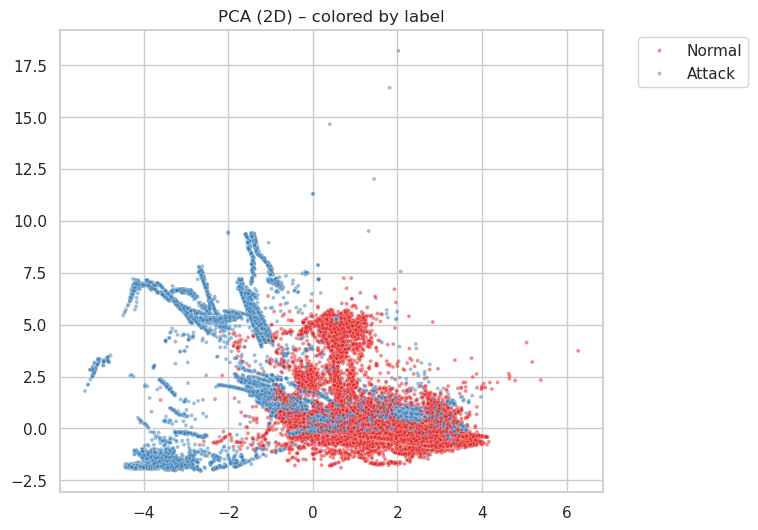

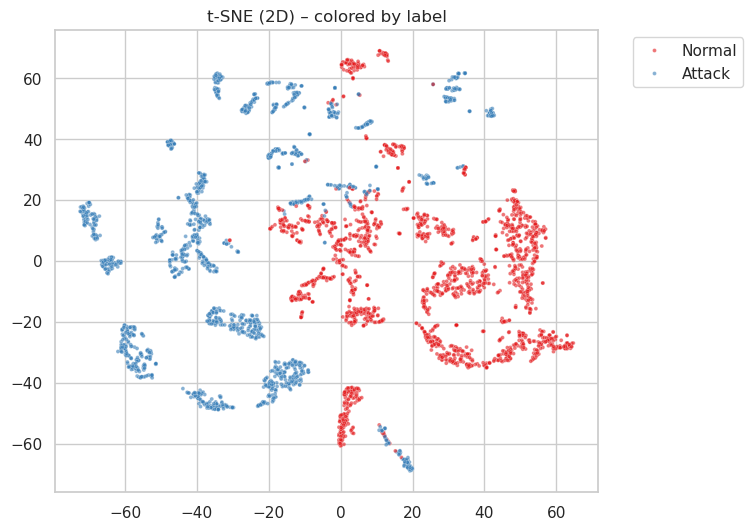

In [8]:
# Cell 8: Unsupervised – PCA (and optional t-SNE) for visualization

# Build unsupervised preprocessing on all data (no label leakage)
unsup_preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), [c for c in X.columns if X[c].dtype == "object"]),
    ],
    remainder="drop",
)
Z = unsup_preprocess.fit_transform(X)

# PCA to 2D/20D
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
Z2 = pca2.fit_transform(Z.toarray() if hasattr(Z, "toarray") else Z)

pca20 = PCA(n_components=min(20, Z.shape[1]-1), random_state=RANDOM_STATE)
Z20 = pca20.fit_transform(Z.toarray() if hasattr(Z, "toarray") else Z)

if label_col:
    color = (df["attack_binary"] if TARGET_MODE == "binary" else y).values
    plt.figure(figsize=(7,6))
    sns.scatterplot(x=Z2[:,0], y=Z2[:,1], hue=color, s=8, alpha=0.5, palette="Set1")
    plt.title("PCA (2D) – colored by label")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.show()

# Optional t-SNE on a sample for visualization
if TSNE_SAMPLE is not None and len(df) > TSNE_SAMPLE:
    idx = np.random.RandomState(RANDOM_STATE).choice(len(df), TSNE_SAMPLE, replace=False)
else:
    idx = np.arange(len(df))

tsne = TSNE(n_components=2, learning_rate="auto", init="pca", random_state=RANDOM_STATE, perplexity=30)
Z_tsne = tsne.fit_transform(Z20[idx])

plt.figure(figsize=(7,6))
if label_col:
    sns.scatterplot(x=Z_tsne[:,0], y=Z_tsne[:,1], hue=(df["attack_binary"].iloc[idx] if TARGET_MODE=="binary" else y.iloc[idx]),
                    s=8, alpha=0.6, palette="Set1")
    plt.title("t-SNE (2D) – colored by label")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
else:
    plt.scatter(Z_tsne[:,0], Z_tsne[:,1], s=8, alpha=0.6)
    plt.title("t-SNE (2D)")
plt.show()

In [9]:
# Cell 9: Unsupervised – KMeans and DBSCAN clustering

# KMeans on PCA-20
kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE, n_init="auto")
km_labels = kmeans.fit_predict(Z20)
print("KMeans silhouette:", silhouette_score(Z20, km_labels))
print("KMeans DB-index:", davies_bouldin_score(Z20, km_labels))
if label_col:
    ari = adjusted_rand_score(y if TARGET_MODE!="binary" else (df["attack_binary"]=="Attack").astype(int), km_labels)
    nmi = normalized_mutual_info_score(y if TARGET_MODE!="binary" else df["attack_binary"], km_labels)
    print(f"KMeans vs labels – ARI: {ari:.3f}, NMI: {nmi:.3f}")

# DBSCAN on PCA-20 (parameters may need tuning)
db = DBSCAN(eps=2.0, min_samples=15, n_jobs=-1)
db_labels = db.fit_predict(Z20)
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print(f"DBSCAN clusters: {n_clusters}, noise points: {(db_labels==-1).sum()}")
valid = db_labels != -1
if valid.sum() > 1 and len(set(db_labels[valid])) > 1:
    print("DBSCAN silhouette (valid only):", silhouette_score(Z20[valid], db_labels[valid]))
if label_col:
    if np.any(valid):
        ari = adjusted_rand_score(y.iloc[valid] if TARGET_MODE!="binary" else (df["attack_binary"].iloc[valid]=="Attack").astype(int), db_labels[valid])
        nmi = normalized_mutual_info_score(y.iloc[valid] if TARGET_MODE!="binary" else df["attack_binary"].iloc[valid], db_labels[valid])
        print(f"DBSCAN vs labels (valid) – ARI: {ari:.3f}, NMI: {nmi:.3f}")

KMeans silhouette: 0.5019721430530203
KMeans DB-index: 1.3311566327025608
KMeans vs labels – ARI: 0.449, NMI: 0.391
DBSCAN clusters: 20, noise points: 662
DBSCAN silhouette (valid only): -2.5862811471679224e-05
DBSCAN vs labels (valid) – ARI: 0.002, NMI: 0.031


In [10]:
# Cell 10: Unsupervised – Outlier detection (IsolationForest, LOF) scored against binary attack (if available)

if label_col:
    y_bin = (df["attack_binary"] == "Attack").astype(int)

    # IsolationForest on PCA-20
    iso = IsolationForest(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1, contamination="auto")
    iso_scores = -iso.fit_predict(Z20)  # +1 normal, -1 outlier -> make higher == more anomalous
    try:
        auc_iso = roc_auc_score(y_bin, iso_scores)
        print(f"IsolationForest ROC-AUC vs Attack: {auc_iso:.3f}")
    except Exception as e:
        print("IsolationForest ROC-AUC error:", e)

    # LocalOutlierFactor (fit on all data; use negative_outlier_factor_)
    lof = LocalOutlierFactor(n_neighbors=35, contamination="auto", n_jobs=-1)
    lof_labels = lof.fit_predict(Z20)
    lof_scores = -lof.negative_outlier_factor_  # higher == more outlier
    try:
        auc_lof = roc_auc_score(y_bin, lof_scores)
        print(f"LOF ROC-AUC vs Attack: {auc_lof:.3f}")
    except Exception as e:
        print("LOF ROC-AUC error:", e)
else:
    print("Outlier detection scoring skipped; no labels.")

IsolationForest ROC-AUC vs Attack: 0.528
LOF ROC-AUC vs Attack: 0.484


In [14]:
# Cell 11: Robust export of artifacts (handles missing best_name/best_pipe)
from pathlib import Path
import json, time
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline  # ensure available

ml_outputs_dir = Path("ml_outputs")
ml_outputs_dir.mkdir(parents=True, exist_ok=True)

def _pick_best_from_cv(cv_df, target_mode="binary"):
    metric_key = 'roc_auc' if target_mode == 'binary' else 'roc_auc_ovr'
    candidates = [f'test_{metric_key}', 'test_f1_macro', 'test_recall_macro', 'test_precision_macro', 'test_accuracy']
    sort_col = next((c for c in candidates if c in cv_df.columns), None)
    if sort_col is None:
        sort_col = cv_df.columns[0]
    name = cv_df[sort_col].idxmax()
    return name, sort_col

# Ensure best_name/best_pipe exist if possible
has_labels = ('y' in globals()) and (y is not None)
has_cv = ('cv_df' in globals())
has_models = ('models' in globals())
has_preprocess = ('preprocess' in globals())

if has_labels and has_cv and has_models and has_preprocess:
    if 'best_name' not in globals() or best_name is None:
        best_name, _ = _pick_best_from_cv(cv_df, TARGET_MODE if 'TARGET_MODE' in globals() else 'binary')

    if 'best_pipe' not in globals():
        # recreate and fit best pipeline
        best_clf = models[best_name]
        best_pipe = Pipeline(steps=[("prep", preprocess), ("clf", best_clf)])
        best_pipe.fit(X_train, y_train)

# Save supervised CV summary and confusion matrix if we have them
if has_labels and ('best_pipe' in globals()) and ('best_name' in globals()):
    try:
        cv_df.to_csv(ml_outputs_dir / "supervised_cv_summary.csv", index=True)
    except Exception:
        pass

    try:
        cm = confusion_matrix(y_test, best_pipe.predict(X_test))
        pd.DataFrame(cm).to_csv(ml_outputs_dir / f"confusion_matrix__{best_name}.csv", index=False)
    except Exception:
        pass

# Save unsupervised cluster labels only if present
to_save = {}
if 'km_labels' in globals():
    to_save['kmeans_label'] = km_labels
if 'db_labels' in globals():
    to_save['dbscan_label'] = db_labels
if to_save:
    pd.DataFrame(to_save).to_csv(ml_outputs_dir / "unsupervised_cluster_labels.csv", index=False)

print("Export complete. Files written to:", ml_outputs_dir.resolve())

Export complete. Files written to: /home/ec2-user/SageMaker/ml_outputs


In [17]:
# Cell: Save trained models and artifacts (Option A: named densifier, picklable)
from pathlib import Path
import json, time
import joblib
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Picklable densifier (replaces lambda)
def to_dense_array(X):
    return X.toarray() if hasattr(X, "toarray") else X

to_dense = FunctionTransformer(to_dense_array, accept_sparse=True, feature_names_out="one-to-one")
dense_models = {"HistGradientBoosting", "MLP", "GradientBoosting"}  # add more if needed

ts = time.strftime("%Y%m%d_%H%M%S")
models_dir = Path("models"); models_dir.mkdir(parents=True, exist_ok=True)

saved = []

def dump(obj, name):
    path = models_dir / f"{ts}__{name}.joblib"
    joblib.dump(obj, path)
    saved.append(str(path))
    return path

# 1) Supervised: save each model re-fit on full train, plus the selected best pipeline
if 'y' in globals() and y is not None and 'X_train' in globals() and 'preprocess' in globals():
    # Save best pipeline (already fit on train)
    if 'best_pipe' in globals() and 'best_name' in globals() and best_name is not None:
        dump(best_pipe, f"supervised__best__{best_name}")

    # Refit and save every model from the benchmarking dict (if available)
    if 'models' in globals():
        for name, clf in models.items():
            steps = [("prep", preprocess)]
            if name in dense_models:
                steps.append(("to_dense", to_dense))
            steps.append(("clf", clf))
            pipe = Pipeline(steps=steps)
            pipe.fit(X_train, y_train)
            dump(pipe, f"supervised__{name}")

    # Save tuned models if present
    if 'rf_cv' in globals():
        dump(rf_cv.best_estimator_, "supervised__rf_tuned_best")
    if 'lr_cv' in globals():
        dump(lr_cv.best_estimator_, "supervised__lr_tuned_best")

    # Save stacking model (fit on full train if only CV was run)
    if 'stack_pipe' in globals():
        try:
            getattr(stack_pipe, "predict")  # ensure fitted
            fitted_stack = stack_pipe
        except Exception:
            stack_pipe.fit(X_train, y_train)
            fitted_stack = stack_pipe
        dump(fitted_stack, "supervised__stacking")

    # Save best-model holdout metrics (if computed)
    metrics = {}
    if 'best_name' in globals() and best_name is not None:
        try:
            y_pred = best_pipe.predict(X_test)
            metrics['classification_report'] = classification_report(y_test, y_pred, output_dict=True)
            metrics['confusion_matrix'] = confusion_matrix(y_test, y_pred).tolist()
            if hasattr(best_pipe, "predict_proba"):
                y_proba = best_pipe.predict_proba(X_test)[:, 1] if len(np.unique(y)) == 2 else None
                if y_proba is not None:
                    metrics['roc_auc'] = float(roc_auc_score(y_test, y_proba))
        except Exception as e:
            metrics['error'] = str(e)

    # Save feature metadata
    feature_meta = {
        "timestamp": ts,
        "X_columns": list(X.columns),
        "numeric_columns": [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])],
        "categorical_columns": [c for c in X.columns if X[c].dtype == "object"],
        "target_mode": TARGET_MODE if 'TARGET_MODE' in globals() else None,
        "label_distribution": (y.value_counts().to_dict() if 'y' in globals() and y is not None else None),
        "best_model_name": best_name if 'best_name' in globals() else None,
        "metrics": metrics,
    }
    with open(models_dir / f"{ts}__supervised__metadata.json", "w", encoding="utf-8") as f:
        json.dump(feature_meta, f, indent=2)

# 2) Unsupervised: save preprocessing + models (if available)
if 'unsup_preprocess' in globals():
    dump(unsup_preprocess, "unsup__preprocess")
if 'pca20' in globals():
    dump(pca20, "unsup__pca20")
if 'kmeans' in globals():
    dump(kmeans, "unsup__kmeans")
    if 'km_labels' in globals():
        pd.DataFrame({"kmeans_label": km_labels}).to_csv(models_dir / f"{ts}__unsup__kmeans_labels.csv", index=False)
if 'db' in globals():
    dump(db, "unsup__dbscan")
    if 'db_labels' in globals():
        pd.DataFrame({"dbscan_label": db_labels}).to_csv(models_dir / f"{ts}__unsup__dbscan_labels.csv", index=False)
if 'iso' in globals():
    dump(iso, "unsup__isolation_forest")
if 'lof' in globals():
    dump(lof, "unsup__lof")

# Optional: save PCA/t-SNE embeddings if you computed them
try:
    if 'Z20' in globals():
        np.save(models_dir / f"{ts}__unsup__Z20.npy", Z20)
    if 'Z_tsne' in globals():
        np.save(models_dir / f"{ts}__unsup__Z_tsne.npy", Z_tsne)
except Exception:
    pass

print("Saved artifacts:")
for p in saved:
    print("-", p)

Saved artifacts:
- models/20250812_120711__supervised__best__RandomForest.joblib
- models/20250812_120711__supervised__LogisticRegression.joblib
- models/20250812_120711__supervised__DecisionTree.joblib
- models/20250812_120711__supervised__RandomForest.joblib
- models/20250812_120711__supervised__GradientBoosting.joblib
- models/20250812_120711__supervised__HistGradientBoosting.joblib
- models/20250812_120711__supervised__SVC_linear.joblib
- models/20250812_120711__supervised__MLP.joblib
- models/20250812_120711__supervised__rf_tuned_best.joblib
- models/20250812_120711__supervised__lr_tuned_best.joblib
- models/20250812_120711__supervised__stacking.joblib
- models/20250812_120711__unsup__preprocess.joblib
- models/20250812_120711__unsup__pca20.joblib
- models/20250812_120711__unsup__kmeans.joblib
- models/20250812_120711__unsup__dbscan.joblib
- models/20250812_120711__unsup__isolation_forest.joblib
- models/20250812_120711__unsup__lof.joblib


In [ ]:
# # Cell: Load a saved supervised pipeline and predict
# import joblib
# from pathlib import Path

# models_dir = Path("models")
# # Pick the latest "best" pipeline
# best_path = sorted(models_dir.glob("*__supervised__best__*.joblib"))[-1]
# best_loaded = joblib.load(best_path)
# print("Loaded:", best_path.name)

# # Example prediction on X_test (ensure the notebook still has X_test)
# y_pred = best_loaded.predict(X_test)
# y_proba = best_loaded.predict_proba(X_test)[:, 1] if hasattr(best_loaded, "predict_proba") else None
# print("Pred sample:", y_pred[:10])